In [26]:
# transfer learning using MobileNet-V3 large 

from tensorflow.keras import Model 
from tensorflow.keras.applications import MobileNetV3Large 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

In [16]:
trainPath = "G:/desktop/project/sweetClassification/sweetDataset/train"
ValidPath = "G:/desktop/project/sweetClassification/sweetDataset/validate"

In [17]:
trainGenerator = ImageDataGenerator(
    rotation_range=15 ,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0, 0.2)).flow_from_directory(trainPath, target_size=(320,320),batch_size=32)

ValidGenerator = ImageDataGenerator(
    rotation_range=15 ,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0, 0.2)).flow_from_directory(ValidPath, target_size=(320,320), batch_size=32)

Found 2083 images belonging to 9 classes.
Found 371 images belonging to 9 classes.


In [18]:
baseModel = MobileNetV3Large(weights= "imagenet", include_top=False)

C:\Users\vishw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\applications\mobilenet_v3.py:512: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


In [19]:
x = baseModel.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
predictionLayer = Dense(9, activation='softmax')(x)

In [20]:
model = Model(inputs=baseModel.input , outputs=predictionLayer)
print(model.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, None, None, 3)     │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)       │ (None, None, None, 3)     │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv (Conv2D)                 │ (None, None, None, 16)    │             432 │ rescaling_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_bn (BatchNormalization)  │ (None, None, None, 16)    │              64 │ conv[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_20 (Activation)    │ (None, None, None, 16)    │               0 │ conv_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, None, None, 16)    │             144 │ activation_20[0][0]        │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_bn    │ (None, None, None, 16)    │              64 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_19 (ReLU)               │ (None, None, None, 16)    │               0 │ expanded_conv_depthwise_b… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, None, None, 16)    │             256 │ re_lu_19[0][0]             │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_bn      │ (None, None, None, 16)    │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_add (Add)       │ (None, None, None, 16)    │               0 │ activation_20[0][0],       │
│                               │                           │                 │ expanded_conv_project_bn[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_1_expand        │ (None, None, None, 64)    │           1,024 │ expanded_conv_add[0][0]    │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_1_expand_bn     │ (None, None, None, 64)    │             256 │ expanded_conv_1_expand[0]… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_20 (ReLU)               │ (None, None, None, 64)    │               

 Total params: 3,653,769 (13.94 MB)

 Trainable params: 3,629,369 (13.84 MB)

 Non-trainable params: 24,400 (95.31 KB)

None


In [21]:
# freeze the layers of the MobileNetV3 (already trained)
for layer in model.layers[:-5]:
    layer.trainable = False

In [22]:
# Compile
# Adjusting the learning rate
optimizer = Adam(learning_rate=0.0001)

# Adding ReduceLROnPlateau callback to dynamically adjust learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [23]:
# train
history = model.fit(trainGenerator, validation_data=ValidGenerator, epochs=15, callbacks=[reduce_lr])

Epoch 1/15


C:\Users\vishw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.2385 - loss: 2.0635 - val_accuracy: 0.4906 - val_loss: 1.5763 - learning_rate: 1.0000e-04
Epoch 2/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.5202 - loss: 1.4381 - val_accuracy: 0.5256 - val_loss: 1.3133 - learning_rate: 1.0000e-04
Epoch 3/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.6134 - loss: 1.1223 - val_accuracy: 0.5876 - val_loss: 1.1799 - learning_rate: 1.0000e-04
Epoch 4/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.6643 - loss: 0.9761 - val_accuracy: 0.5822 - val_loss: 1.1536 - learning_rate: 1.0000e-04
Epoch 5/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.6846 - loss: 0.9500 - val_accuracy: 0.6092 - val_loss: 1.0896 - learning_rate: 1.0000e-04
Epoch 6/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.7188 - loss: 0.8342 - val_accuracy: 0.6496 - val_loss: 1.0583 - learning_rate: 1.0000e-04
Epoch 7/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.7348 - loss: 0.8

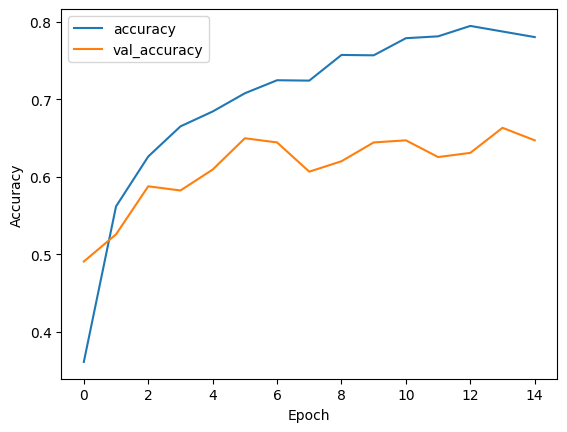

In [24]:
# Plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

It seems like model is overfitted we need to fine tune our model

In [29]:
# Add dropout and l2 regularization to dense layers
x = baseModel.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)  # Adding dropout
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)  # Adding dropout
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)  # Adding dropout

predictionLayer = Dense(9, activation='softmax')(x)

model1 = Model(inputs=baseModel.input, outputs=predictionLayer)

# Freeze the layers of the MobileNetV3 (already trained)
for layer in model1.layers[:-8]:
    layer.trainable = False

# Compile
optimizer = Adam(learning_rate=0.0001)
model1.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Implement Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with increased epochs
history1 = model1.fit(trainGenerator, validation_data=ValidGenerator, epochs=50, callbacks=[early_stopping])


Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.1196 - loss: 14.2317 - val_accuracy: 0.1617 - val_loss: 13.1936
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.1459 - loss: 13.1873 - val_accuracy: 0.2642 - val_loss: 12.4927
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.1519 - loss: 12.4871 - val_accuracy: 0.3639 - val_loss: 11.8515
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.1977 - loss: 11.7892 - val_accuracy: 0.4124 - val_loss: 11.2159
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.2160 - loss: 11.1251 - val_accuracy: 0.4420 - val_loss: 10.5988
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.2861 - loss: 10.5218 - val_accuracy: 0.4636 - val_loss: 10.0260
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.2944 - loss: 10.0032 - val_accuracy: 0.4663 - val_loss: 9.5053
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.3224 - loss: 9.4737 - val_accurac

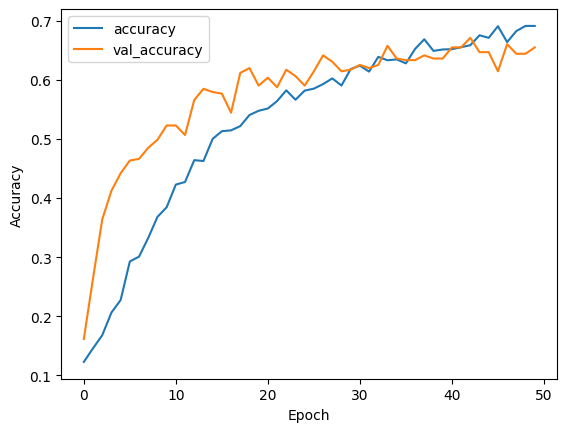

In [31]:
plt.plot(history1.history['accuracy'], label='accuracy')
plt.plot(history1.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

After doing some hyperparamenter tuning model training and validation accuracy is increasing upto 50 epoch and I think it requare more epoch 
but to make more robust model we need more precise data 

In [33]:
model1.save('sweet_model.keras')